# Imports

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from PIL import Image

# Reorder of the images for better access and splitting

I will save all the images inside a new folder called breast_images, which will contain the folders of all the patitents (client_id), and inside it will contain the images of said patient with the name of the image_id

In [ ]:
base_path = '/OPTIMAM/images/'  # Original path
new_base_path = 'breast_images/'  # New path
csv_file = 'assets/client_images_screening.csv'

# Read CSV
df = pd.read_csv(csv_file)

# Ensure directories exist
if not os.path.exists(new_base_path):
    os.makedirs(new_base_path)

# Debug: Print total clients found
print(f"Total unique clients in CSV: {len(df['client_id'].unique())}")

# Process each client
for client_id in tqdm(df['client_id'].unique(), desc="Processing Clients"):
    client_data = df[df['client_id'] == client_id]
    patient_path = os.path.join(base_path, client_id)
    client_new_path = os.path.join(new_base_path, client_id)

    if not os.path.exists(client_new_path):
        os.makedirs(client_new_path)

    if os.path.exists(patient_path):
        for study_folder in tqdm(os.listdir(patient_path), desc=f"Processing Studies for {client_id}", leave=False):
            study_path = os.path.join(patient_path, study_folder)
            if os.path.isdir(study_path):
                for img_file in tqdm(os.listdir(study_path), desc="Processing Images", leave=False):
                    img_path = os.path.join(study_path, img_file)
                    image_id = os.path.basename(img_path).rsplit('.', 1)[0]
                    image_data = client_data[client_data['image_id'] == image_id]

                    if not image_data.empty:
                        try:
                            image = Image.open(img_path)
                            image_np = np.array(image)

                            # Crop the image
                            xmin, xmax, ymin, ymax = image_data[['xmin_cropped', 'xmax_cropped', 'ymin_cropped', 'ymax_cropped']].iloc[0].astype(int)
                            cropped_image = image_np[ymin:ymax, xmin:xmax]

                            # Save cropped image
                            cropped_image_pil = Image.fromarray(cropped_image)
                            save_path = os.path.join(client_new_path, img_file)
                            cropped_image_pil.save(save_path)
                        except Exception as e:
                            print(f"An error occurred with file {img_path}: {e}, skipping...")
                    else:
                        print(f"No data for image ID {image_id} in client {client_id}, skipping...")
            else:
                print(f"Study path not a directory: {study_path}, skipping...")
    else:
        print(f"Client path does not exist: {patient_path}, skipping...")

**We generated 6000 folders a.k.a 6000 clients**

*Example print on how to show all the images from a certain client after data reordering*

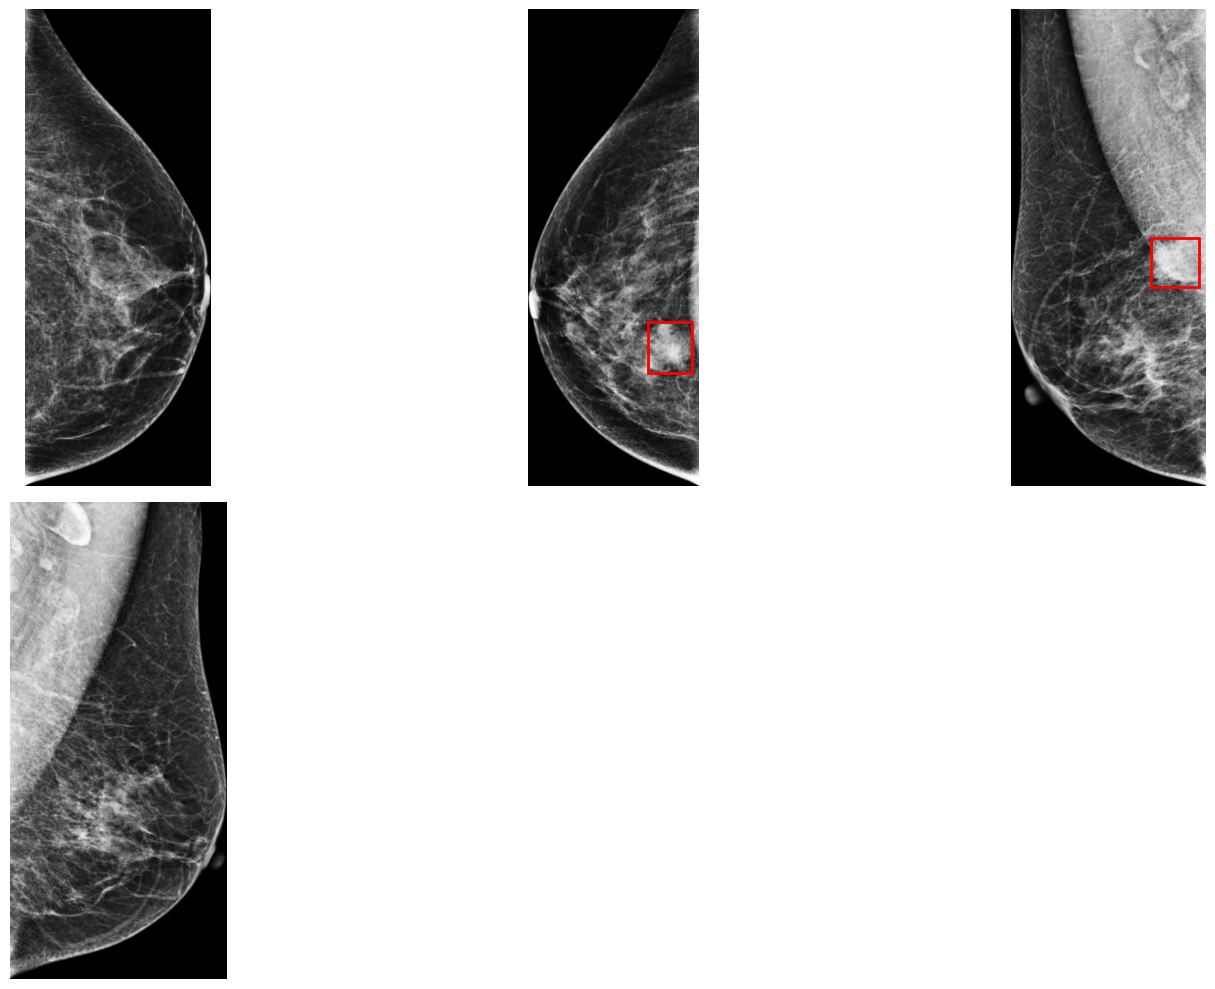

In [5]:
client_id = 'client_id'
base_path = 'test/'
csv_file = 'assets/client_images_screening.csv'

# Read CSV and filter for the specific client_id
df = pd.read_csv(csv_file)
client_data = df[df['client_id'] == client_id]

client_path = os.path.join(base_path, client_id)

image_paths = []

for root, dirs, files in os.walk(client_path):
    for file in files:
        if file.endswith(".png"):
            image_paths.append(os.path.join(root, file))

num_images = len(image_paths)
num_cols = 3
num_rows = num_images // num_cols + (num_images % num_cols > 0)

plt.figure(figsize=(15, 5 * num_rows))

for i, img_path in enumerate(image_paths, 1):
    # Extract image_id from the filename correctly
    image_id = os.path.basename(img_path).rsplit('.', 1)[0]
    
    image_data = client_data[client_data['image_id'] == image_id]

    if not image_data.empty:
        image = Image.open(img_path)
        image_np = np.array(image)

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        # Draw rectangle for lesion location
        xmin, xmax, ymin, ymax = image_data[['xmin_cropped', 'xmax_cropped', 'ymin_cropped', 'ymax_cropped']].iloc[0].astype(int)
        x1, x2, y1, y2 = image_data[['x1', 'x2', 'y1', 'y2']].iloc[0]
        plt.gca().add_patch(plt.Rectangle((x1 - xmin, y1 - ymin), x2 - x1, y2 - y1, fill=False, edgecolor='red', lw=2))

    else:
        print(f"No data found for image ID: {image_id}")

plt.tight_layout()
plt.show()